## Analyze dimensionality by computing mutual information x dimensions

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import confusion
from confusion import generate_confusion_matrix
from data_loader import SessionDataLoader
from spikes.filters import gaussian_filter, exp_filter
from spikes.binning import bin_spikes
from template_decoding import (
    compute_distances_to_templates,
    compute_templates,
    decode,
    prepare,
    template_selectors,
    get_plotty_lines,
)

%load_ext autoreload
%autoreload 2

In [6]:
data_loader = SessionDataLoader("GreBlu9508M", 2)
table = data_loader.load_table()

In [7]:
table = table[table["call_type"] != "None"]
table = table.copy()

In [8]:
t_arr, spikes = bin_spikes(table["spike_times"], min_time=0.0, max_time=0.6)
spikes_filtered = exp_filter(spikes, 5.0)

table["binned_spikes"] = spikes.tolist()
table["psth"] = spikes_filtered.tolist()

In [39]:
unit_table = table[table["unit"] == (21, 1)]
unit_table = unit_table.copy()
unit_table = prepare(unit_table, "stim")

In [48]:
DIMS = [2, 3, 5, 8, 13, 21, 34]

In [40]:
def decode_after_pca(unit_table, template_column="stim", ndim=2):
    """Generate confusion matrix after running pca on data

    Applies PCA on the psth column of the dataset and generates
    a confusion matrix using nearest template decoding.

    Modifies the input dataframe by adding a new column called "resp"
    that represents the "psth" in a lower dimensional space (PCA)

    Parameters
    ----------
    unit_table : pd.DataFrame (n_datapoints, ... )
        Dataframe with a Series `template_column` indicating the
        category being decoded, and a Series "psth" for the response
        data
    template_column : string (default="stim")
        Name of column containing category labels
    ndim : int (default=2)
        Number of principal components to keep on PCA step

    Returns
    -------
    confusion_matrix : np.ndarray (n_stims, n_stims)
        Confusion matrix normalized so that each row sums to 1
        (i.e. represents P(predicted stim | actual stim))
    """
    if ndim:
        pca = PCA(n_components=ndim)
        # save the reduced representation of responses to "resp" column
        unit_table["resp"] = pca.fit_transform(unit_table["psth"].tolist()).tolist()
    else:
        unit_table["resp"] = unit_table["psth"].tolist()

    selectors, categories = template_selectors(unit_table, "resp")
    distances = compute_distances_to_templates(unit_table, selectors, "resp")

    predicted = decode(unit_table, distances, categories)
    actual = unit_table.index

    return generate_confusion_matrix(actual, predicted, categories, joint=False)

In [42]:
for dim in DIMS:
    conf = decode_after_pca(unit_table, template_column="stim", ndim=dim)
    mutual_information = confusion.mutual_information(conf)
    print "{:.2f} bits at dim {}".format(mutual_information, dim)

3.14 bits at dim 2


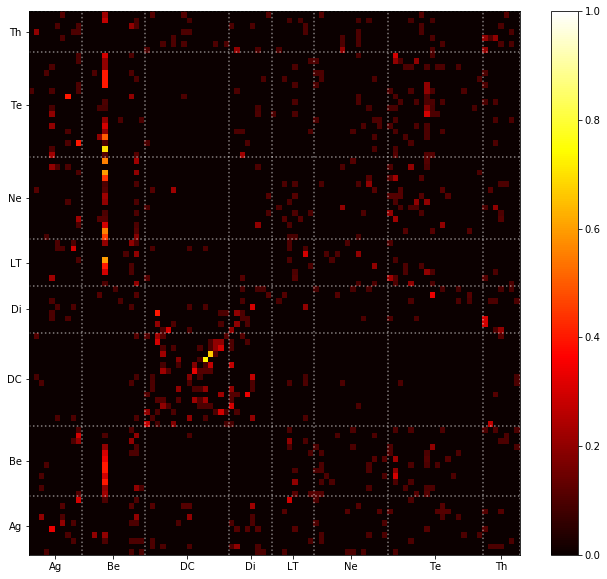

Mutual Information: 3.14 bits
Accuracy: 7.66%


In [44]:
barriers, labels, label_posititions = get_plotty_lines(unit_table)
plt.figure(figsize=(11, 10))
plt.pcolormesh(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.hlines(barriers, 0, barriers[-1], color="white", linestyles=":", alpha=0.5)
plt.vlines(barriers, 0, barriers[-1], color="white", linestyles=":", alpha=0.5)
plt.xticks(label_posititions, labels)
plt.yticks(label_posititions, labels)
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)

Okay now we shuffle the data

In [45]:
unit_table = table[table["unit"] == (21, 1)]
unit_table = unit_table.copy()
unit_table = prepare(unit_table, "stim")
unit_table["psth"] = unit_table["psth"].sample(frac=1).tolist()

In [46]:
for dim in DIMS:
    conf = decode_after_pca(unit_table, template_column="stim", ndim=dim)
    mutual_information = confusion.mutual_information(conf)
    print "{:.2f} bits at dim {}".format(mutual_information, dim)

2.20 bits at dim 2


/auto/fhome/kevin/Projects/furry-guacamole/src/template_decoding.py:100: FutureWarning: 'stim' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """


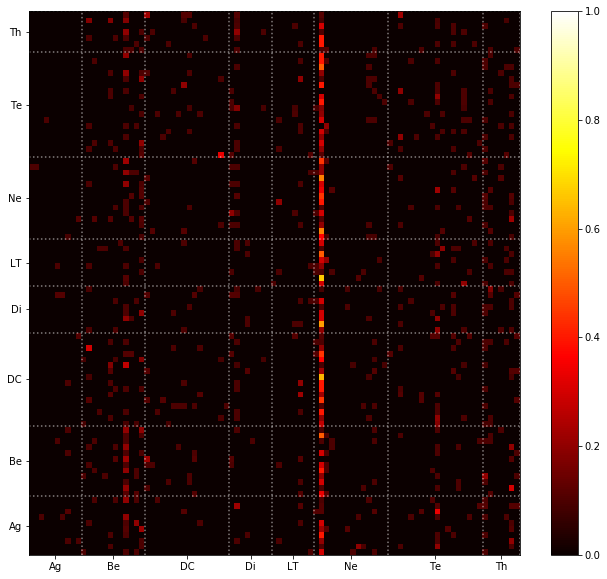

Mutual Information: 2.20 bits
Accuracy: 1.91%


In [47]:
barriers, labels, label_posititions = get_plotty_lines(unit_table)
plt.figure(figsize=(11, 10))
plt.pcolormesh(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.hlines(barriers, 0, barriers[-1], color="white", linestyles=":", alpha=0.5)
plt.vlines(barriers, 0, barriers[-1], color="white", linestyles=":", alpha=0.5)
plt.xticks(label_posititions, labels)
plt.yticks(label_posititions, labels)
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)